In [1]:
from collections import deque
import random

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm

In [2]:
env = gym.make('CartPole-v1')
env.reset()

discount_factor = 0.95
eps = 0.5
eps_min = 0.01
eps_decay = 0.99
learning_rate = 0.8
num_episodes = 50
batch_size = 32

In [3]:
scores = []
memory = deque(maxlen=2000)

for i in tqdm(range(num_episodes), position=0, leave=True):
    state = env.reset()
    done = False
    score = 0
    #while game not ended
    while not done:
        new_state, reward, done, _, _ = env.step(env.action_space.sample())
        score += reward
        state = new_state
    scores.append(score)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5097.35it/s]


In [4]:
#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#Using a neural network to learn our policy parameters
class QLearningNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(QLearningNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(observation_space, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_space)
        )
    
    #forward pass
    def forward(self, x):
        return self.model(x)

In [5]:
#Init network
model = QLearningNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    if isinstance(state, tuple):
        state = state[0]
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    q_vals = network(state)
    
    #sample an action using the probability distribution
    action = torch.argmax(q_vals)
    max_value = torch.max(q_vals)
    
    #return action
    return action.item(), q_vals, max_value

In [7]:
scores = []

memory = deque(maxlen=4000)

for i in tqdm(range(num_episodes), position=0, leave=True):
    state = env.reset()
    done = False
    eps *= eps_decay
    score = 0
    #while game not ended
    while not done:
        env.render()
        if isinstance(state, tuple):
            state = state[0]
        #choose move with epsilon greedy
        if np.random.random() < eps:
            #exploration
            action = np.random.randint(0, env.action_space.n)
        else:
            #exploitation
            #use expand_dims here to add a dimension for input layer
#             q_vals = model(state_torch)#.to('cpu').detach().numpy()
#             action = torch.argmax(q_vals).item()
            action = select_action(model, np.expand_dims(state, axis=0))[0]
        
        #execute move
        new_state, reward, done, _, _ = env.step(action)
        score += reward
        
        #modify reward so it scales with pole angle. Pole angle range [-0.418, 0.418]
        reward = 1 - abs(state[2])/0.418
        
        #memorize
        memory.append([np.expand_dims(state, axis=0), action, reward, np.expand_dims(new_state, axis=0), done])
        
        #update
        #instead of training every state, we train in batch_size
        if len(memory) > batch_size:
            #sample batch_size so model could be fit on any random states in memory not just the latest state
            minibatch = random.sample(memory, batch_size)
            
            #iterate through the sampled batch
            for b_state, b_action, b_reward, b_new_state, b_done in minibatch:
                #if current game is done then target = reward cuz theres no future utility
                if b_done:
                    target = b_reward
                else:
                    #what we think the state's q_val should be, reward + discounted future utility
                    target = b_reward + discount_factor * select_action(model, b_new_state)[2]
                
                #what we thought the current state's q_val should be
                target_vector = select_action(model, b_state)[1]
                
                #update the target_vector 
                target_vector[0][0][b_action] = target
                
                #instead of finding temporal difference between new q_val and old q_val, we train the model by giving it the new q_val
                # and let the network do the updating 
                #train the model with the batch
                loss = loss_fn(select_action(model, b_state)[1], target_vector)
                optimizer.zero_grad()
                loss.backward()
                
#                 for param in model.parameters():
#                     print(param.grad.data.sum())
                
                step = optimizer.step()

            #update epsilon
            if eps > eps_min:
                eps *= eps_decay
                
        #new state
        state = new_state
    scores.append(score)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [22:40<00:00, 27.21s/it]


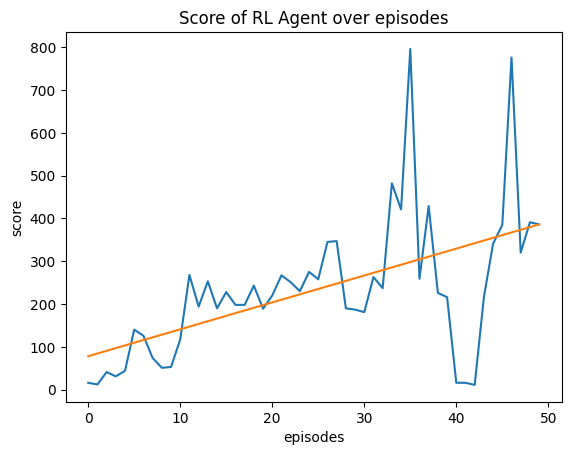

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Score of RL Agent over episodes')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)

In [9]:
scores = []
while len(scores) < 50:
    state = env.reset()
    done = False
    score = 0
    while not done:
        score += 1
#            env.render()
        action = select_action(model, state)[0]

        new_state, _, done, _,_ = env.step(action)
        state = new_state
    scores.append(score)

In [10]:
np.array(scores).mean()

294.46